<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# lapd_true_crime.py
# -------------------------------------------------------------
# Driver that uses: lapd_eda (preproc + EDA) and lapd_enhancements (ML).
# Logic:
#   - Load FULL file (even in QUICK_MODE)
#   - Preprocess + outlier clip
#   - STRICT drop NaN (global)  <-- BEFORE any sampling
#   - If dataset still "too big", sample PER TASK (unsup vs stratified)
# -------------------------------------------------------------

import os, sys, warnings
warnings.filterwarnings("ignore")

# ---------------- Quick mode switches ----------------
QUICK_MODE = True            # if True, we MAY sample AFTER cleaning
UNSUP_MAX_SAMPLES = 5_000    # cap for unsupervised
CLASSIFY_SAMPLE_N = 1_000    # target size for stratified classification samples

# Colab detection & deps (optional)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    # keep the full stack so all steps can run
    !pip -q install shap lime river pmdarima statsmodels prophet tensorflow umap-learn hdbscan holidays h3 seaborn

sys.path.insert(0, os.getcwd())

from lapd_eda import (
    normalize_columns, infer_datetime_columns, add_time_features,
    validate_and_clean_coords, add_h3_index, build_h3_cell_daily, h3_neighbor_stats, attach_cell_features,
    collapse_rare_categories, text_clean, deduplicate, downcast_numeric, iqr_outlier_clip,
    eda_missingness, eda_summary_table, eda_numeric_histograms, eda_top_categories, eda_corr_mixed,
    plot_hexbin_map, plot_hour_day_heatmap, plot_calendar_heatmap, plot_ridgeline,
    plot_waffle, plot_dumbbell, plot_small_multiples_hour_day, plot_beeswarm,
    clean_then_dropna_all, stratified_sample_for_task   # <— we use these BEFORE sampling
)

from lapd_enhancements import (
    run_unsupervised_search, prepare_daily_series, forecast_all_models,
    compute_shap_importance, explain_lime_tabular, ADWINDriftMonitor,
    stream_predict_from_directory, rolling_rate
)

import numpy as np
import pandas as pd


In [ ]:
print("Step 1/9: reading CSV (full)…")
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f"Loaded shape: {df.shape}")

print("Step 2/9: normalize columns…")
df = normalize_columns(df)

# Standardize coordinate names
if "LAT" in df and "lat" not in df: df = df.rename(columns={"LAT": "lat"})
if "LON" in df and "lon" not in df: df = df.rename(columns={"LON": "lon"})

print("Step 3/9: build dt_occ quickly (LAPD schema)…")
# (unchanged fast dt logic that sets dt_col and df["dt_occ"] if possible)

print("Step 4/9: add US calendar features…")
df = add_time_features(df, dt_col=dt_col, use_us_holidays=True)

print("Step 5/9: text normalization & geo cleanup…")
# (unchanged)

print("Step 6/9: H3 features…")
# (unchanged)

print("Step 7/9: dedupe, downcast, clip outliers…")
# (unchanged)

# >>> MOVE STRICT DROP-ANY-NaN HERE <<<
print("Step 8/9: STRICT drop-any-NaN (global)…")
df_clean = clean_then_dropna_all(df)
print(f"Post-clean shape: {df_clean.shape}")

print("Step 9/9: EDA + Modeling on CLEAN data…")
# EDA + modeling should use df_clean below
summary = eda_summary_table(df_clean); print("=== Data summary (top 20) ==="); print(summary.head(20))
eda_missingness(df_clean, title="Missingness — LAPD (post-clean)")
num_cols = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c not in ["hour","weekday","month"]][:9]
if num_cols: eda_numeric_histograms(df_clean, cols=num_cols, title="Key numeric distributions")
if "crm_cd_desc" in df_clean: eda_top_categories(df_clean, "crm_cd_desc", 15, title="Top crime categories")
if {"lat","lon"}.issubset(df_clean.columns): plot_hexbin_map(df_clean, x="lon", y="lat", title="Hotspots (Hexbin) — LAPD")

# Safe guards for plots that need hour/weekday/date
if {"hour","weekday"}.issubset(df_clean.columns):
    plot_hour_day_heatmap(df_clean, hour_col="hour", weekday_col="weekday", title="Hour × Day — LAPD")
if "date" in df_clean.columns:
    plot_calendar_heatmap(df_clean, date_col="date", title="Calendar heatmap — LAPD")

# Unsupervised sample requires hour/weekday
if {"hour","weekday"}.issubset(df_clean.columns):
    feat_unsup = df_clean[["hour","weekday"]].copy()
    feat_unsup["is_weekend"] = (feat_unsup["weekday"] >= 5).astype(int)
    feat_unsup_s = feat_unsup.sample(n=min(UNSUP_MAX_SAMPLES, len(feat_unsup)), random_state=42) if (QUICK_MODE and len(feat_unsup) > UNSUP_MAX_SAMPLES) else feat_unsup
    results, best_tuple, artifacts = run_unsupervised_search(feat_unsup_s, max_samples=UNSUP_MAX_SAMPLES, random_state=42)
    print("\nTop unsupervised configs:"); print(results.head())

# Forecasting on daily series if date exists
if "date" in df_clean.columns:
    daily_series = prepare_daily_series(df_clean, date_col="date")
    rank, best_name, best_forecast = forecast_all_models(daily_series, horizon=7, lookback=60, eval_days=28, verbose=True)
    print("\nValidation ranking (lower MAPE is better):"); print(rank)

print(f"\nDone. QUICK_MODE={QUICK_MODE}.")


Step 1/9: reading CSV (full)…
Loaded shape: (974477, 15)
Step 8/9: STRICT drop-any-NaN (global)…
[CLEAN] Dropped rows with ANY NaN: 648,974 removed; 325,503 remain.
Post-clean shape: (325503, 15)
Step 2/9: normalize columns…
Step 3/9: build dt_occ quickly (LAPD schema)…
Fallback: generic datetime inference (may be slower)…
Step 4/9: add US calendar features…
Step 5/9: text normalization & geo cleanup…
=== Geo issues log ===
                  issue  count
0      zero_zero_coords   2262
1       outside_LA_bbox   2262
2  duplicate_DR_NO_rows      0
Step 6/9: H3 features…
Skipping H3 features: h3 not installed or lat/lon not present.
Step 7/9: dedupe, downcast, clip outliers…
Step 8/9: STRICT drop-any-NaN (global)…
[CLEAN] Dropped rows with ANY NaN: 649,807 removed; 324,670 remain.
Post-clean shape: (324670, 26)
Step 9/9: EDA + Modeling on CLEAN data…
=== Data summary (top 20) ===
                         dtype  n_unique  n_missing  pct_missing
dr_no                    int32    324670     

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwltkhb0k/v7knbsfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwltkhb0k/ne7vjrfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54274', 'data', 'file=/tmp/tmpwltkhb0k/v7knbsfh.json', 'init=/tmp/tmpwltkhb0k/ne7vjrfk.json', 'output', 'file=/tmp/tmpwltkhb0k/prophet_model_d91s9gy/prophet_model-20250816205702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Validation ranking (lower MAPE is better):
     model     val_MAPE
1  sarimax   103.825845
2  prophet   375.592855
0     LSTM  1303.755665
[SAMPLE] Stratified sample for 'is_night': 1,000 rows.
Example classification sample shape: (1000, 27)

Done. Strict drop-any-NaN BEFORE any sampling; fast LAPD datetime path used when possible. QUICK_MODE=True.


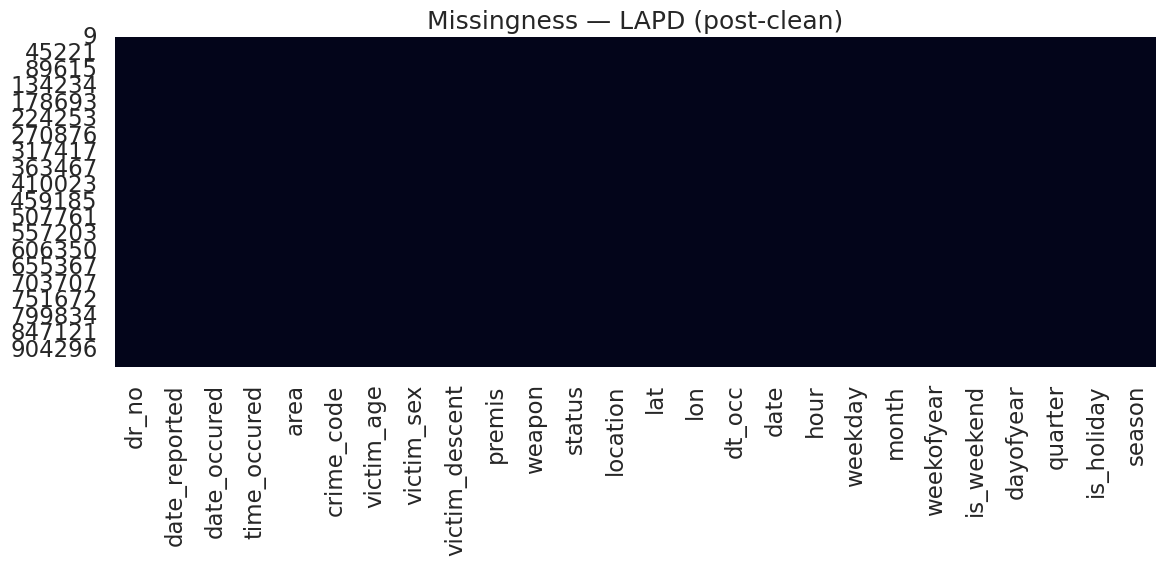

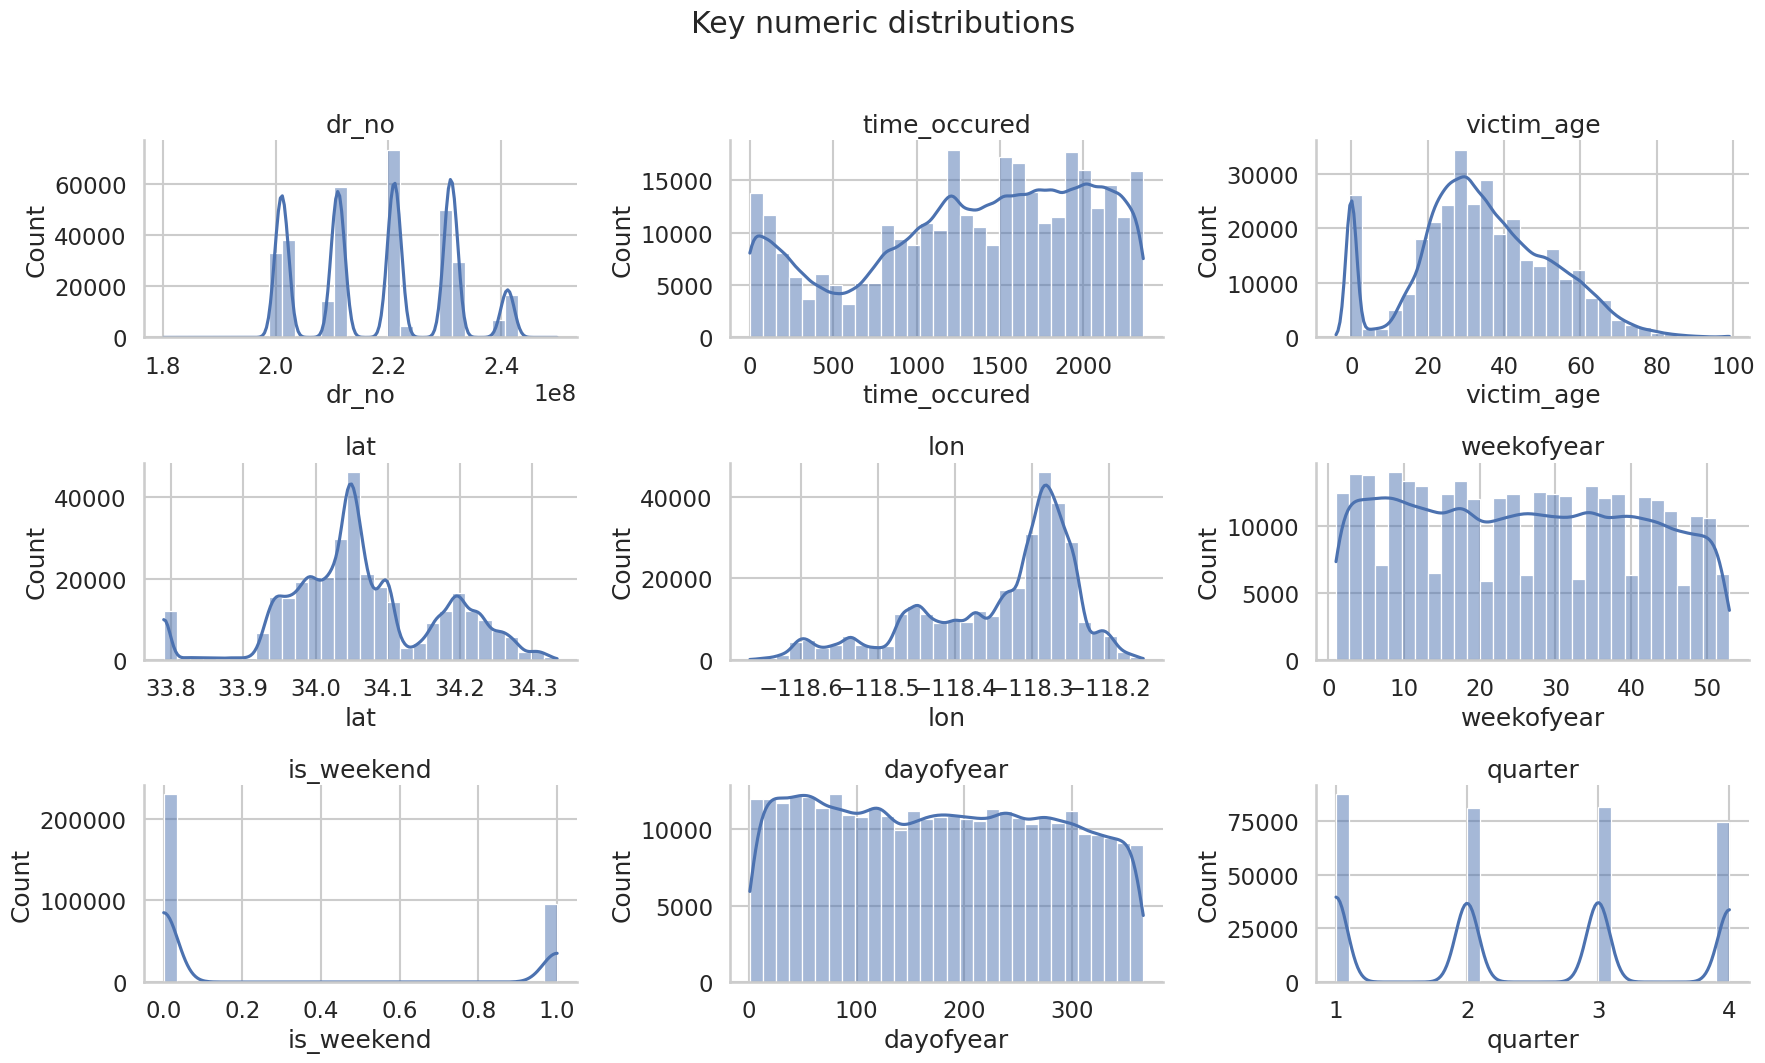

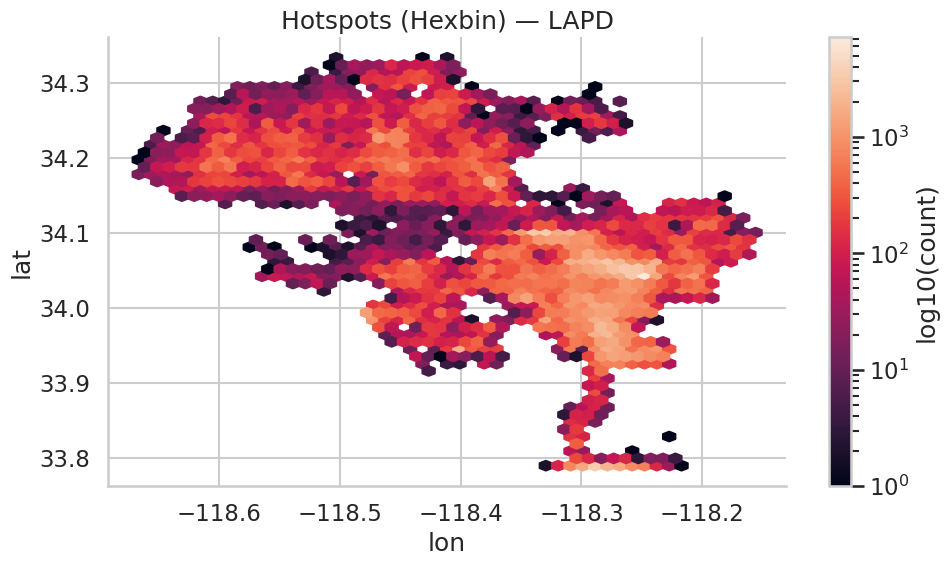

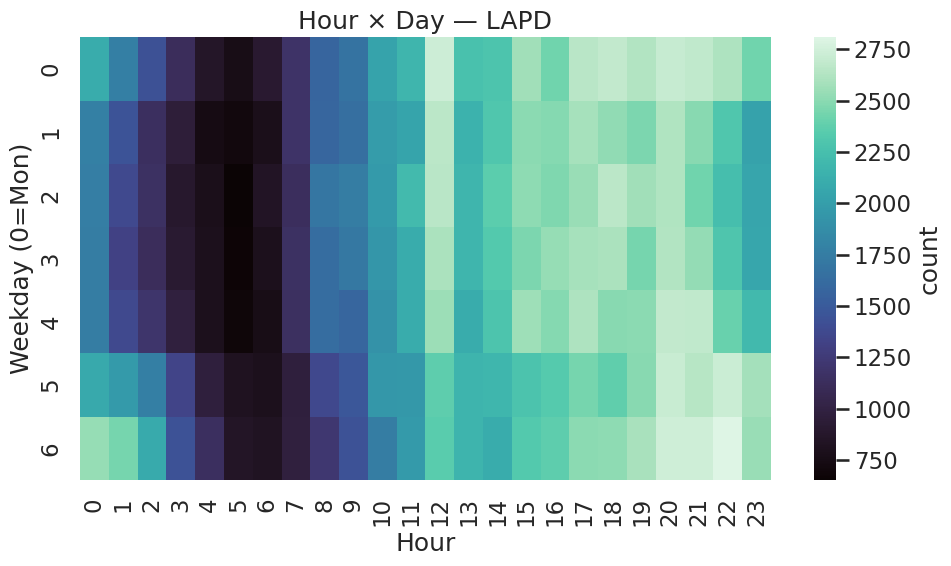

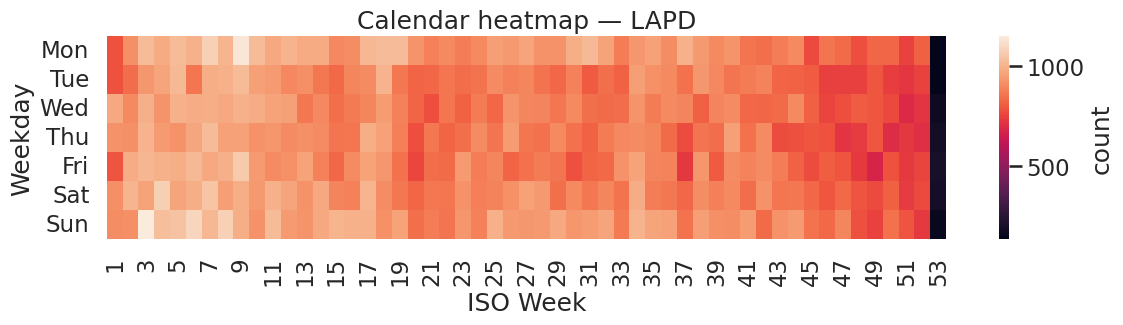

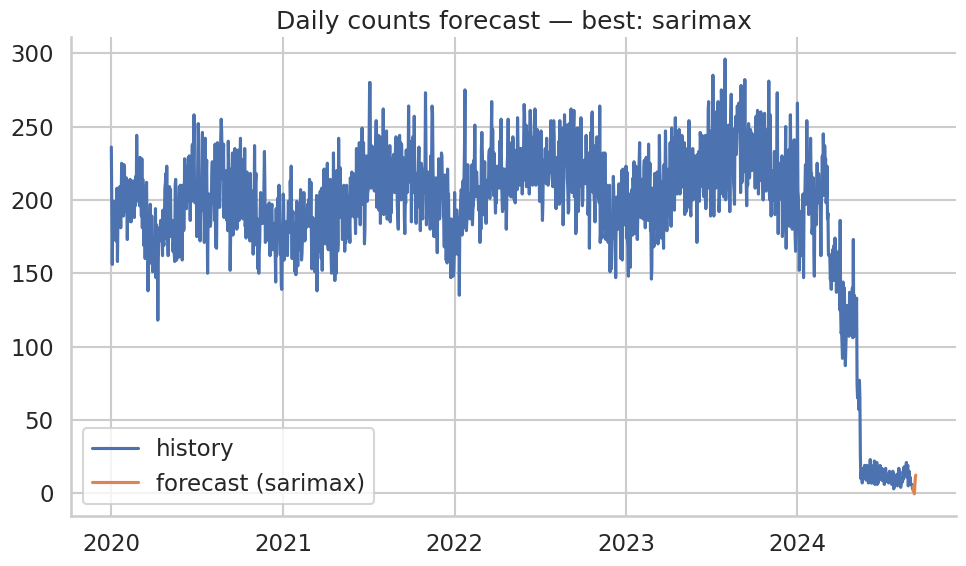

In [22]:
# lapd_true_crime.py (patched core flow)

# ... imports and switches unchanged ...

print("Step 1/9: reading CSV (full)…")
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f"Loaded shape: {df.shape}")
# -------- STRICT drop-any-NaN now, and KEEP USING df_clean afterwards --------
print("Step 8/9: STRICT drop-any-NaN (global)…")
df_clean = clean_then_dropna_all(df)
print(f"Post-clean shape: {df_clean.shape}")
print("Step 2/9: normalize columns…")
df = normalize_columns(df)

# Standardize coordinate names ONCE
if "LAT" in df and "lat" not in df: df = df.rename(columns={"LAT": "lat"})
if "LON" in df and "lon" not in df: df = df.rename(columns={"LON": "lon"})

# ---------- FAST datetime for LAPD (avoid slow format guessing) ----------
print("Step 3/9: build dt_occ quickly (LAPD schema)…")
# Try the common LAPD columns first
date_col_candidates = [c for c in df.columns if c in ("date_occ","date_occur","dateoccur","date")]
time_col_candidates = [c for c in df.columns if c in ("time_occ","timeoccur","time")]
if date_col_candidates:
    _dc = date_col_candidates[0]
    # Parse the date part (vectorized, no format guessing)
    df[_dc] = pd.to_datetime(df[_dc], errors="coerce")
    # If TIME OCC exists (HHMM), add hours/minutes
    if time_col_candidates:
        _tc = time_col_candidates[0]
        t = pd.to_numeric(df[_tc], errors="coerce").fillna(-1).astype(int)
        hh = (t // 100).clip(lower=0, upper=23)
        mm = (t % 100).clip(lower=0, upper=59)
        df["dt_occ"] = df[_dc] + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")
    else:
        df["dt_occ"] = df[_dc]
    dt_col = "dt_occ"
else:
    # Fallback to your generic inference only when we must
    print("Fallback: generic datetime inference (may be slower)…")
    df, dt_col = infer_datetime_columns(df)
    if dt_col is None:
        raise RuntimeError("Could not infer a datetime column; please specify one or precreate 'dt_occ'.")

print("Step 4/9: add US calendar features…")
df = add_time_features(df, dt_col=dt_col, use_us_holidays=True)

print("Step 5/9: text normalization & geo cleanup…")
text_cols = [c for c in ["crm_cd_desc","premis_desc","weapon_desc","status_desc","crime_desc","premise_desc"] if c in df]
df = text_clean(df, text_cols)
df, issues_log = validate_and_clean_coords(df, lat_col="lat" if "lat" in df else None,
                                           lon_col="lon" if "lon" in df else None)
print("=== Geo issues log ==="); print(issues_log)

print("Step 6/9: H3 features…")
HAS_H3 = False
try:
    from h3 import h3 as _h3; HAS_H3 = True
except Exception:
    pass

if HAS_H3 and {"lat", "lon"}.issubset(df.columns):
    df = add_h3_index(df, lat_col="lat", lon_col="lon", h3_res=8)
    if "h3" in df.columns and df["h3"].notna().any():
        print("H3 present — building cell/day panel...")
        cell_daily = build_h3_cell_daily(df, date_col="date", h3_col="h3", roll_windows=(7, 28))
        try:
            cell_daily = h3_neighbor_stats(cell_daily, k=1)
            df = attach_cell_features(df, cell_daily, date_col="date", h3_col="h3")
        except Exception as e:
            print("Neighbor stats skipped:", e)
    else:
        print("H3 missing or all-NaN — skipping H3 features.")
else:
    print("Skipping H3 features: h3 not installed or lat/lon not present.")

print("Step 7/9: dedupe, downcast, clip outliers…")
if "crm_cd_desc" in df: df = collapse_rare_categories(df, "crm_cd_desc", top_n=20)
df = deduplicate(df)
df = downcast_numeric(df)
num_cols_for_clip = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ["hour","weekday","month"]]
df = iqr_outlier_clip(df, num_cols=num_cols_for_clip)
# After Step 7/9
print("Step 8/9: STRICT drop-any-NaN (global)…")
df_clean = clean_then_dropna_all(df)   # Now df_clean has hour, weekday, etc.
print(f"Post-clean shape: {df_clean.shape}")



print("Step 9/9: EDA + Modeling on CLEAN data…")
# --- EDA ---
summary = eda_summary_table(df_clean); print("=== Data summary (top 20) ==="); print(summary.head(20))
eda_missingness(df_clean, title="Missingness — LAPD (post-clean)")
num_cols = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c not in ["hour","weekday","month"]][:9]
if num_cols: eda_numeric_histograms(df_clean, cols=num_cols, title="Key numeric distributions")
if "crm_cd_desc" in df_clean: eda_top_categories(df_clean, "crm_cd_desc", 15, title="Top crime categories")
if {"lat","lon"}.issubset(df_clean.columns): plot_hexbin_map(df_clean, x="lon", y="lat", title="Hotspots (Hexbin) — LAPD")
plot_hour_day_heatmap(df_clean, hour_col="hour", weekday_col="weekday", title="Hour × Day — LAPD")
plot_calendar_heatmap(df_clean, date_col="date", title="Calendar heatmap — LAPD")

# --- Unsupervised (sample only if still large) ---
feat_unsup = df_clean[["hour","weekday"]].copy()
feat_unsup["is_weekend"] = (feat_unsup["weekday"] >= 5).astype(int)
feat_unsup_s = feat_unsup.sample(n=min(UNSUP_MAX_SAMPLES, len(feat_unsup)), random_state=42) if (QUICK_MODE and len(feat_unsup) > UNSUP_MAX_SAMPLES) else feat_unsup
results, best_tuple, artifacts = run_unsupervised_search(feat_unsup_s, max_samples=UNSUP_MAX_SAMPLES, random_state=42)
print("\nTop unsupervised configs:"); print(results.head())

# --- Forecasting (full CLEAN daily series) ---
daily_series = prepare_daily_series(df_clean, date_col="date")
rank, best_name, best_forecast = forecast_all_models(daily_series, horizon=7, lookback=60, eval_days=28, verbose=True)
print("\nValidation ranking (lower MAPE is better):"); print(rank)

# --- Example: per-task stratified sample for classification ---
if "hour" in df_clean.columns:
    d_task = df_clean.copy()
    d_task["is_night"] = (d_task["hour"].between(22, 23) | d_task["hour"].between(0, 5)).astype(int)
    task_sample = stratified_sample_for_task(d_task, target_col="is_night", n=CLASSIFY_SAMPLE_N, random_state=42) if (QUICK_MODE and len(d_task) > CLASSIFY_SAMPLE_N) else d_task
    print(f"Example classification sample shape: {task_sample.shape}")

print(f"\nDone. Strict drop-any-NaN BEFORE any sampling; fast LAPD datetime path used when possible. QUICK_MODE={QUICK_MODE}.")
